In [2]:
import nltk
import string
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib as plt
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [3]:
msgs=[line.rstrip() for line in open('../datasets/SMSSpamCollection/SMSSpamCollection')]

In [4]:
print len(msgs)

5574


In [5]:
for num, msg in enumerate(msgs[:5]):
    print num, msg
    print '\n'

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


1 ham	Ok lar... Joking wif u oni...


2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


3 ham	U dun say so early hor... U c already then say...


4 ham	Nah I don't think he goes to usf, he lives around here though




In [6]:
df_msgs = pd.read_csv('../datasets/SMSSpamCollection/SMSSpamCollection', 
                   sep='\t', names=['labels','message'])

In [7]:
df_msgs.describe()

,labels,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [16]:
df_msgs.groupby('labels').describe()

message
labels                                                          
ham    count                                                4825
       unique                                               4516
       top                                Sorry, I'll call later
       freq                                                   30
spam   count                                                 747
       unique                                                653
       top     Please call our customer service representativ...
       freq                                                    4

In [8]:
df_msgs['length'] = df_msgs['message'].apply(len)

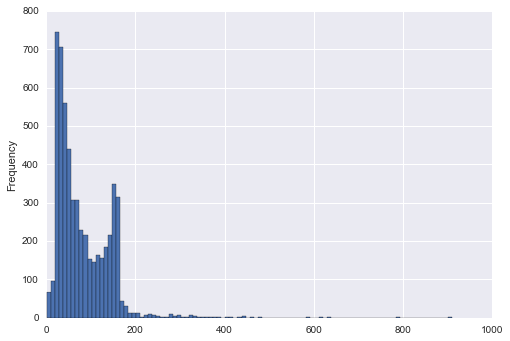

In [9]:
df_msgs['length'].plot(bins=100, kind='hist')

In [22]:
df_msgs[df_msgs['length']==910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

(0, 250)

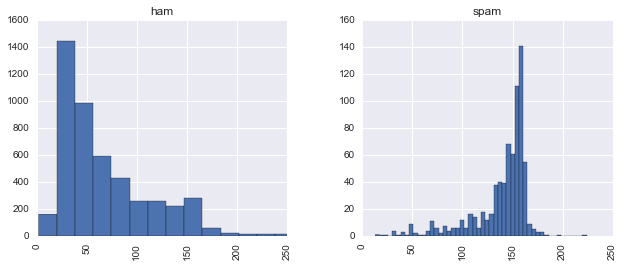

In [29]:
ax_list = df_msgs.hist(column='length',by='labels',bins=50,figsize=(10,4))
ax_list[0].set_xlim((0,250))
ax_list[1].set_xlim((0,250))

In [10]:
def clean_text(message):
    nopunc = [char for char in message if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower not in stopwords.words('english')]

In [11]:
bow_transformer = CountVectorizer(analyzer = clean_text)

In [12]:
bow_transformer.fit(df_msgs['message'])

CountVectorizer(analyzer=<function clean_text at 0x11736a1b8>, binary=False,
        decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
        stop_words=None, strip_accents=None,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None,
        vocabulary=None)

In [13]:
msg4 = df_msgs['message'][3]

In [38]:
print msg4

U dun say so early hor... U c already then say...


In [39]:
bow4 = bow_transformer.transform([msg4])
print bow4

  (0, 4221)	2
  (0, 4828)	1
  (0, 5476)	1
  (0, 6427)	1
  (0, 6447)	1
  (0, 7427)	1
  (0, 9832)	2
  (0, 10174)	1
  (0, 10703)	1


In [42]:
print bow_transformer.get_feature_names()[9832]

say


In [43]:
msgs_bow = bow_transformer.transform(df_msgs['message'])

In [47]:
print 'Shape of Sparse Matrix: ', msgs_bow.shape
print 'Amount of non-zero occurences: ', msgs_bow.nnz
print 'sparsity: %.2f%%' % (100.0 * msgs_bow.nnz / (msgs_bow.shape[0] * msgs_bow.shape[1]))

Shape of Sparse Matrix:  (5572, 11747)
Amount of non-zero occurences:  79463
sparsity: 0.12%


In [49]:
tfidf_transformer = TfidfTransformer().fit(msgs_bow)

In [50]:
tfidf4 = tfidf_transformer.transform(bow4)

In [51]:
print tfidf4

  (0, 10703)	0.221482852564
  (0, 10174)	0.193450513267
  (0, 9832)	0.514749313079
  (0, 7427)	0.419528360236
  (0, 6447)	0.304628956074
  (0, 6427)	0.28629349827
  (0, 5476)	0.284154050159
  (0, 4828)	0.254427694692
  (0, 4221)	0.390271188407


In [52]:
print tfidf_transformer.idf_[bow_transformer.vocabulary_['u']]

3.28005242674


In [53]:
msgs_tfidf = tfidf_transformer.transform(msgs_bow)

In [54]:
print msgs_tfidf.shape

(5572, 11747)


In [56]:
spam_detect_model = MultinomialNB().fit(msgs_tfidf, df_msgs['labels'])

In [58]:
print 'predicted: ', spam_detect_model.predict(tfidf4)[0]
print 'expected : ', df_msgs['labels'][3]

 predicted:  ham
expected :  ham


In [60]:
all_predictions = spam_detect_model.predict(msgs_tfidf)
print all_predictions

['ham' 'ham' 'spam' ..., 'ham' 'ham' 'ham']


In [61]:
print classification_report(df_msgs['labels'], all_predictions)

             precision    recall  f1-score   support

        ham       0.97      1.00      0.98      4825
       spam       1.00      0.79      0.88       747

avg / total       0.97      0.97      0.97      5572



In [63]:
msg_train, msg_test, label_train, labe_test = \
train_test_split(df_msgs['message'],df_msgs['labels'],test_size=0.2)

In [64]:
print len(msg_train), len(msg_test), len(msg_train) + len(msg_test)

4457 1115 5572


In [68]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=clean_text)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [69]:
pipeline.fit(msg_train, label_train)

Pipeline(steps=[('bow', CountVectorizer(analyzer=<function clean_text at 0x117493d70>, binary=False,
        decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,...         use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [70]:
predictions = pipeline.predict(msg_test)

In [72]:
print classification_report(predictions, labe_test)

             precision    recall  f1-score   support

        ham       1.00      0.95      0.97      1016
       spam       0.64      1.00      0.78        99

avg / total       0.97      0.95      0.96      1115



In [17]:
from os import path
from wordcloud import WordCloud

In [8]:
df_msgs = pd.read_csv('../datasets/SMSSpamCollection/SMSSpamCollection', 
                   sep='\t', names=['labels','message'])

In [14]:
text = df_msgs['message']

In [15]:
print text

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
5       FreeMsg Hey there darling it's been 3 week's n...
6       Even my brother is not like to speak with me. ...
7       As per your request 'Melle Melle (Oru Minnamin...
8       WINNER!! As a valued network customer you have...
9       Had your mobile 11 months or more? U R entitle...
10      I'm gonna be home soon and i don't want to tal...
11      SIX chances to win CASH! From 100 to 20,000 po...
12      URGENT! You have won a 1 week FREE membership ...
13      I've been searching for the right words to tha...
14                    I HAVE A DATE ON SUNDAY WITH WILL!!
15      XXXMobileMovieClub: To use your credit, click ...
16                             Oh k...i'm watching here:)
17      Eh u r

In [19]:
wordcloud = WordCloud().generate(str(text))

(-0.5, 399.5, 199.5, -0.5)

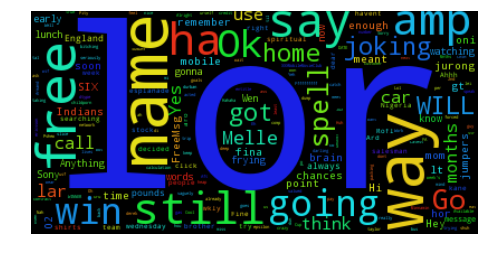

In [20]:
import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis("off")

In [17]:
# image = wordcloud.to_image()
# image.show()

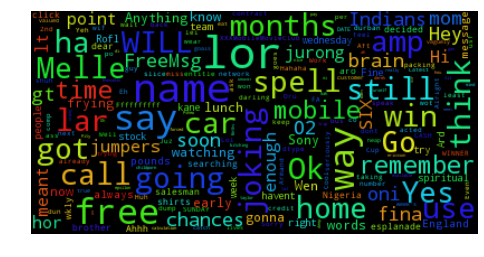

In [19]:
wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(str(text))
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [21]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

In [23]:
alice_mask = np.array(Image.open("images/bird_mask.png"))

In [24]:
wc = WordCloud(background_color="white", max_words=2000, mask=alice_mask,
               stopwords=STOPWORDS.add("said"))

In [26]:
wc.generate(str(text))

In [28]:
wc.to_file("images/alice.png")

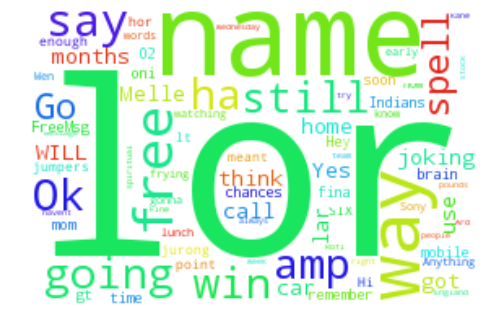

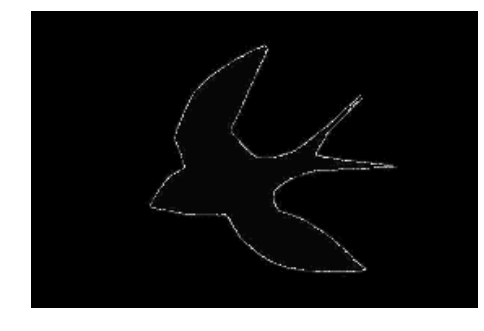

In [29]:

plt.imshow(wc)
plt.axis("off")
plt.figure()
plt.imshow(alice_mask, cmap=plt.cm.gray)
plt.axis("off")
plt.show()